## Loading required dependencies

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
#Importing libraries
import cv2
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt 

## Loading cropped image

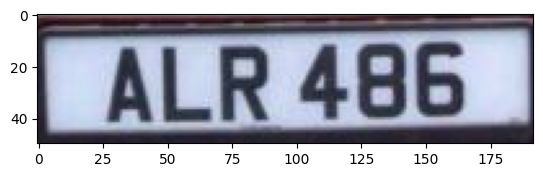

In [3]:
#Load the previously cropped image
cropped_img = cv2.imread('/content/gdrive/Shareddrives/Character_images/cropped_img.jpg')
plt.imshow(cropped_img)
plt.show()

## Image Preprocessing 

In [4]:
# Image preprocessing to sharpen image

def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        #detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        #checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            #extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) #List that stores the character's binary image (unsorted)
            
    #Return characters on ascending order with respect to the x-coordinate (most-left character first)
    plt.axis('off')
    plt.show()
    #arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [5]:
# Find individual characters in the preprocessed images

def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75)) #resize
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY) # converting it to grayscale
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU) # inverting colors.. black background, white letters/numbers
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))  # dilate makes contours more visible to be detected later. 

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6, # ORIGINALLY 6, move up to get tall contours. 
                       LP_WIDTH/1.8,#2
                       LP_HEIGHT/10, #10
                       2*LP_HEIGHT/3] #2*3
    plt.imshow(img_binary_lp, cmap='gray')
    plt.axis('off')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

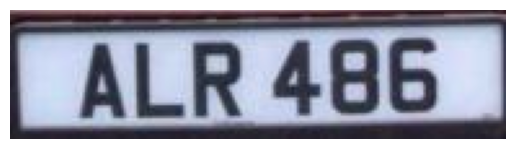

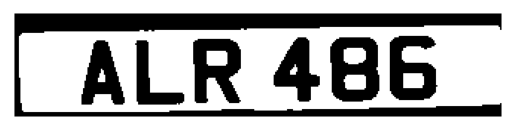

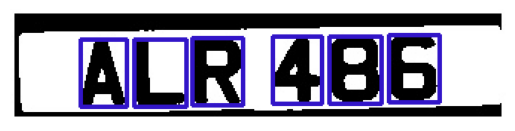

In [6]:
#Show preprocessing results
plt.imshow(cropped_img)
plt.axis('off')
plt.show()
char = segment_characters(cropped_img)

In [8]:
#How many characters were detected?
char.shape

(6, 44, 24)

In [9]:
#Save the individual images as np arrays
np.save('char.npy', char)

In [10]:
# Save the individual images of characters to Google Drive
save_path = '/content/gdrive/Shareddrives/Character_images/plate_chars'
np.save(save_path, char)
print("Image saved to google drive")

Image saved to google drive


In [11]:
#Load individual images
chars = np.load('/content/gdrive/Shareddrives/Character_images/plate_chars.npy')
print("Image of individual characters loaded")

Image of individual characters loaded


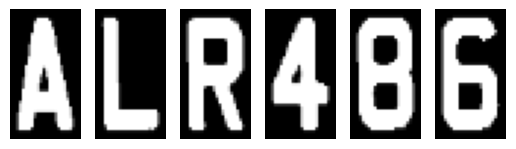

In [14]:
#Show individual images
for i in range(chars.shape[0]):
    plt.subplot(1, chars.shape[0], i+1)
    plt.imshow(chars[i], cmap='gray')
    plt.axis('off')

In [17]:
#Show one of the individual images
#plt.imshow(chars[3], cmap='gray')

In [107]:
#This individual characters are going to be fed into my own NN arquitecture to predict the Characters of the licence plate. 